# Mixture distributions

In [12]:
from IPython import get_ipython

if get_ipython():
    get_ipython().run_line_magic("load_ext", "autoreload")
    get_ipython().run_line_magic("autoreload", "2")

import numpy as np
import pandas as pd
import seaborn as sns
import scipy

import latenta as la

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Generative model

In [13]:
n_cells = 500
cell_ids = [str(i) for i in range(n_cells)]

cells = la.Dim(pd.Series(cell_ids, name="cell"))

x_value = pd.Series(np.random.uniform(0, 5, n_cells), index=cells.index)
x = la.Fixed(x_value, label="x")

In [14]:
distributions_gs = {
    "a": la.distributions.Normal(5.0, 1.0, definition=la.Definition([cells])),
    "b": la.distributions.Laplace(-1.0, 1.0, definition=la.Definition([cells])),
    "c": la.distributions.Normal(10.0, 1.0, definition=la.Definition([cells])),
}
distributions_dim = la.Dim(list(distributions_gs.keys()), "distribution")

In [15]:
w = pd.DataFrame(
    np.vstack([x_value * 2, np.sqrt(x_value), 2 * (x_value - 3) ** 2]),
    index=distributions_dim.index,
    columns=cells.index,
).T
w = w / w.sum(1).values[:, None]
w = la.Fixed(w)

In [16]:
mixture = la.distributions.Mixture(distributions = distributions_gs, weight=w, label="mixture")


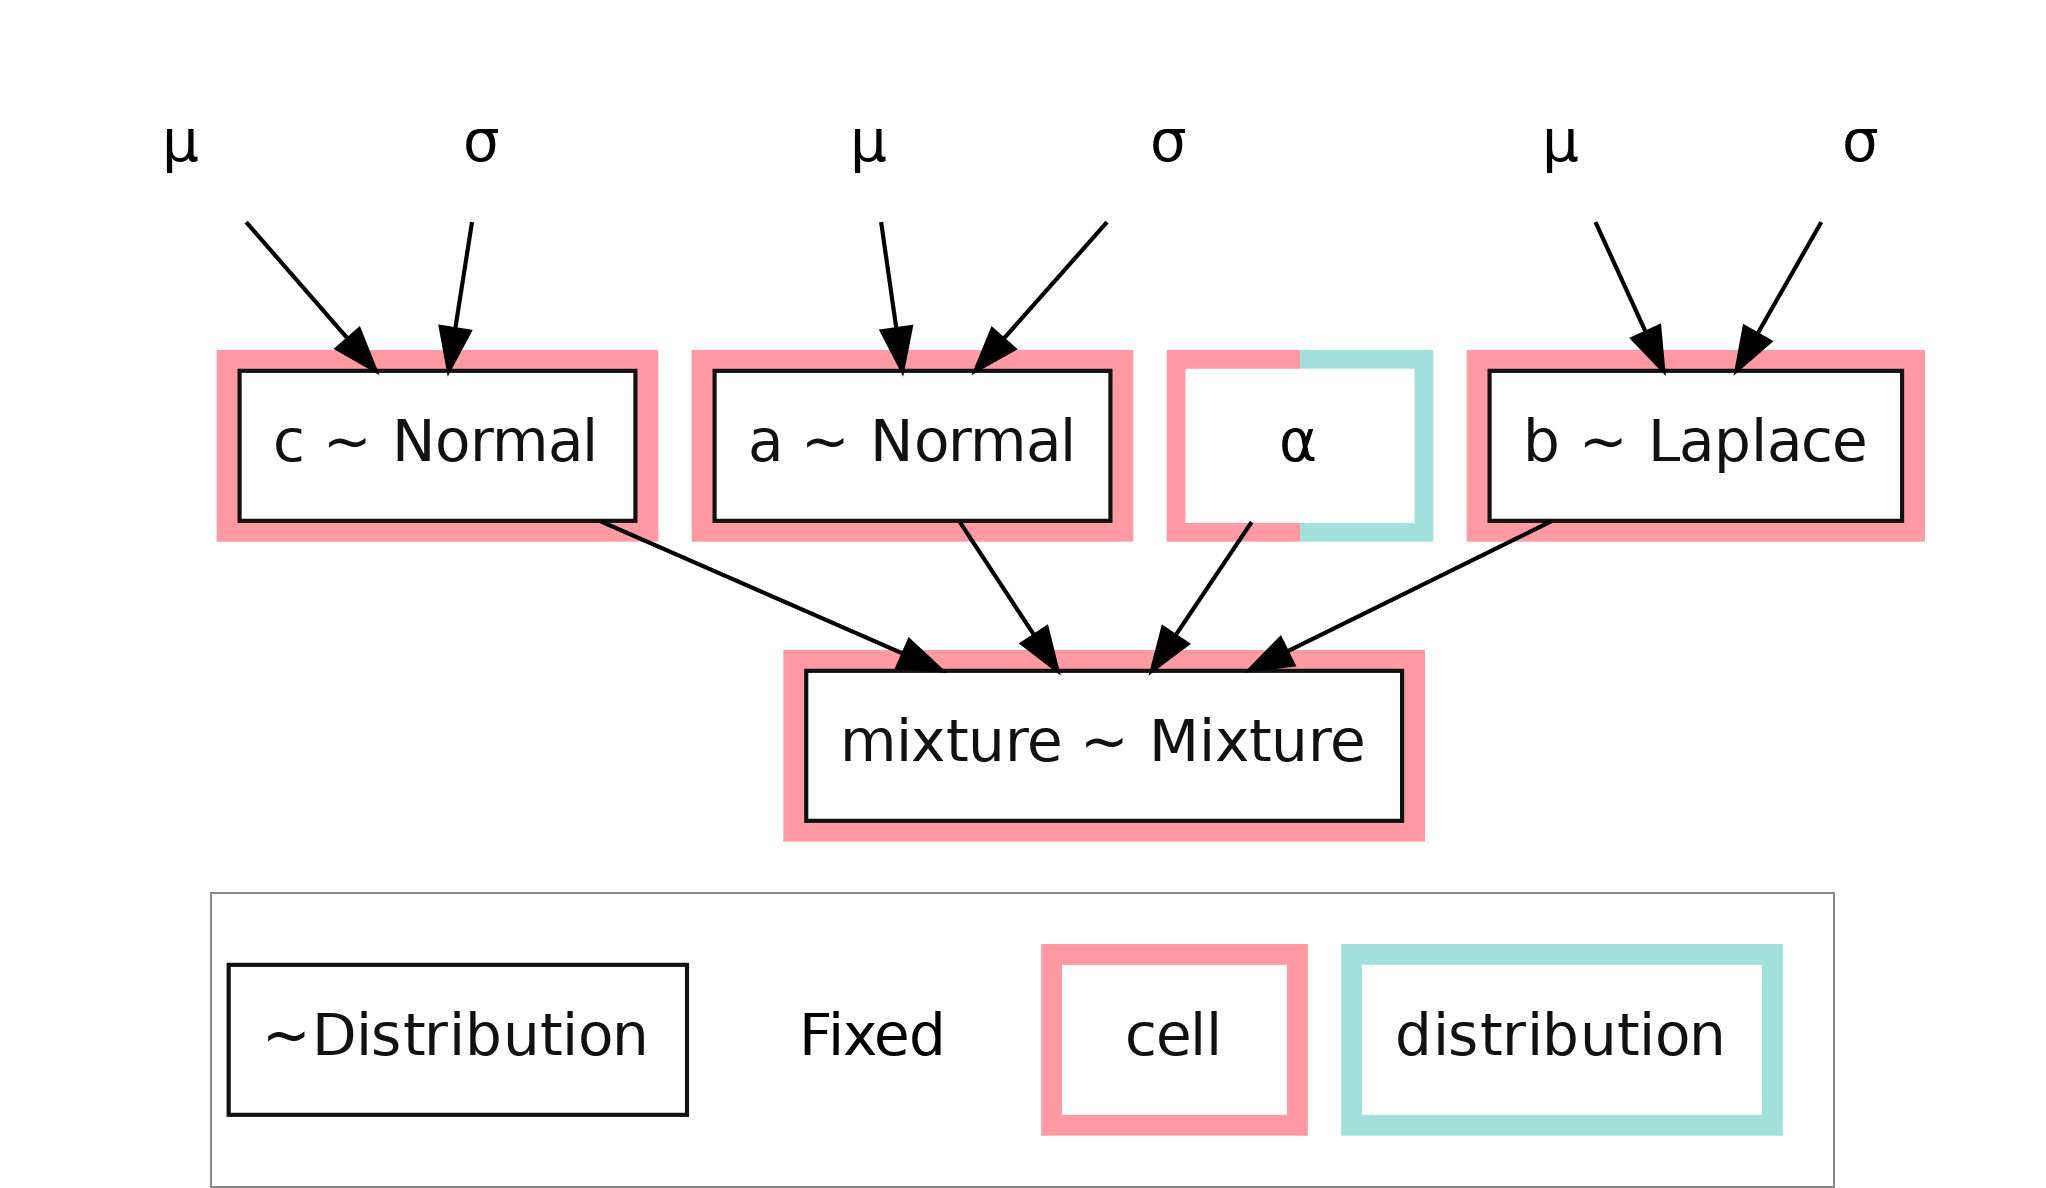

In [17]:
mixture.plot()

In [18]:
model_gs = la.Model(mixture)
x_gs = x

In [19]:
posterior = la.posterior.Posterior(mixture)
posterior.sample(1)

  0%|          | 0/1 [00:00<?, ?it/s]

<AxesSubplot:>

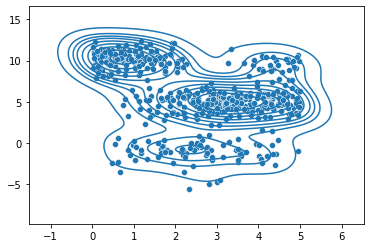

In [20]:
observation_value = posterior.samples[mixture].sel(sample=0).to_pandas()
sns.scatterplot(x=x_value, y=observation_value)
sns.kdeplot(x=x_value, y=observation_value)

In [21]:
kde_groundtruth = scipy.stats.gaussian_kde(np.vstack([x_value, observation_value]))

## Modelling the mixture weights with given x


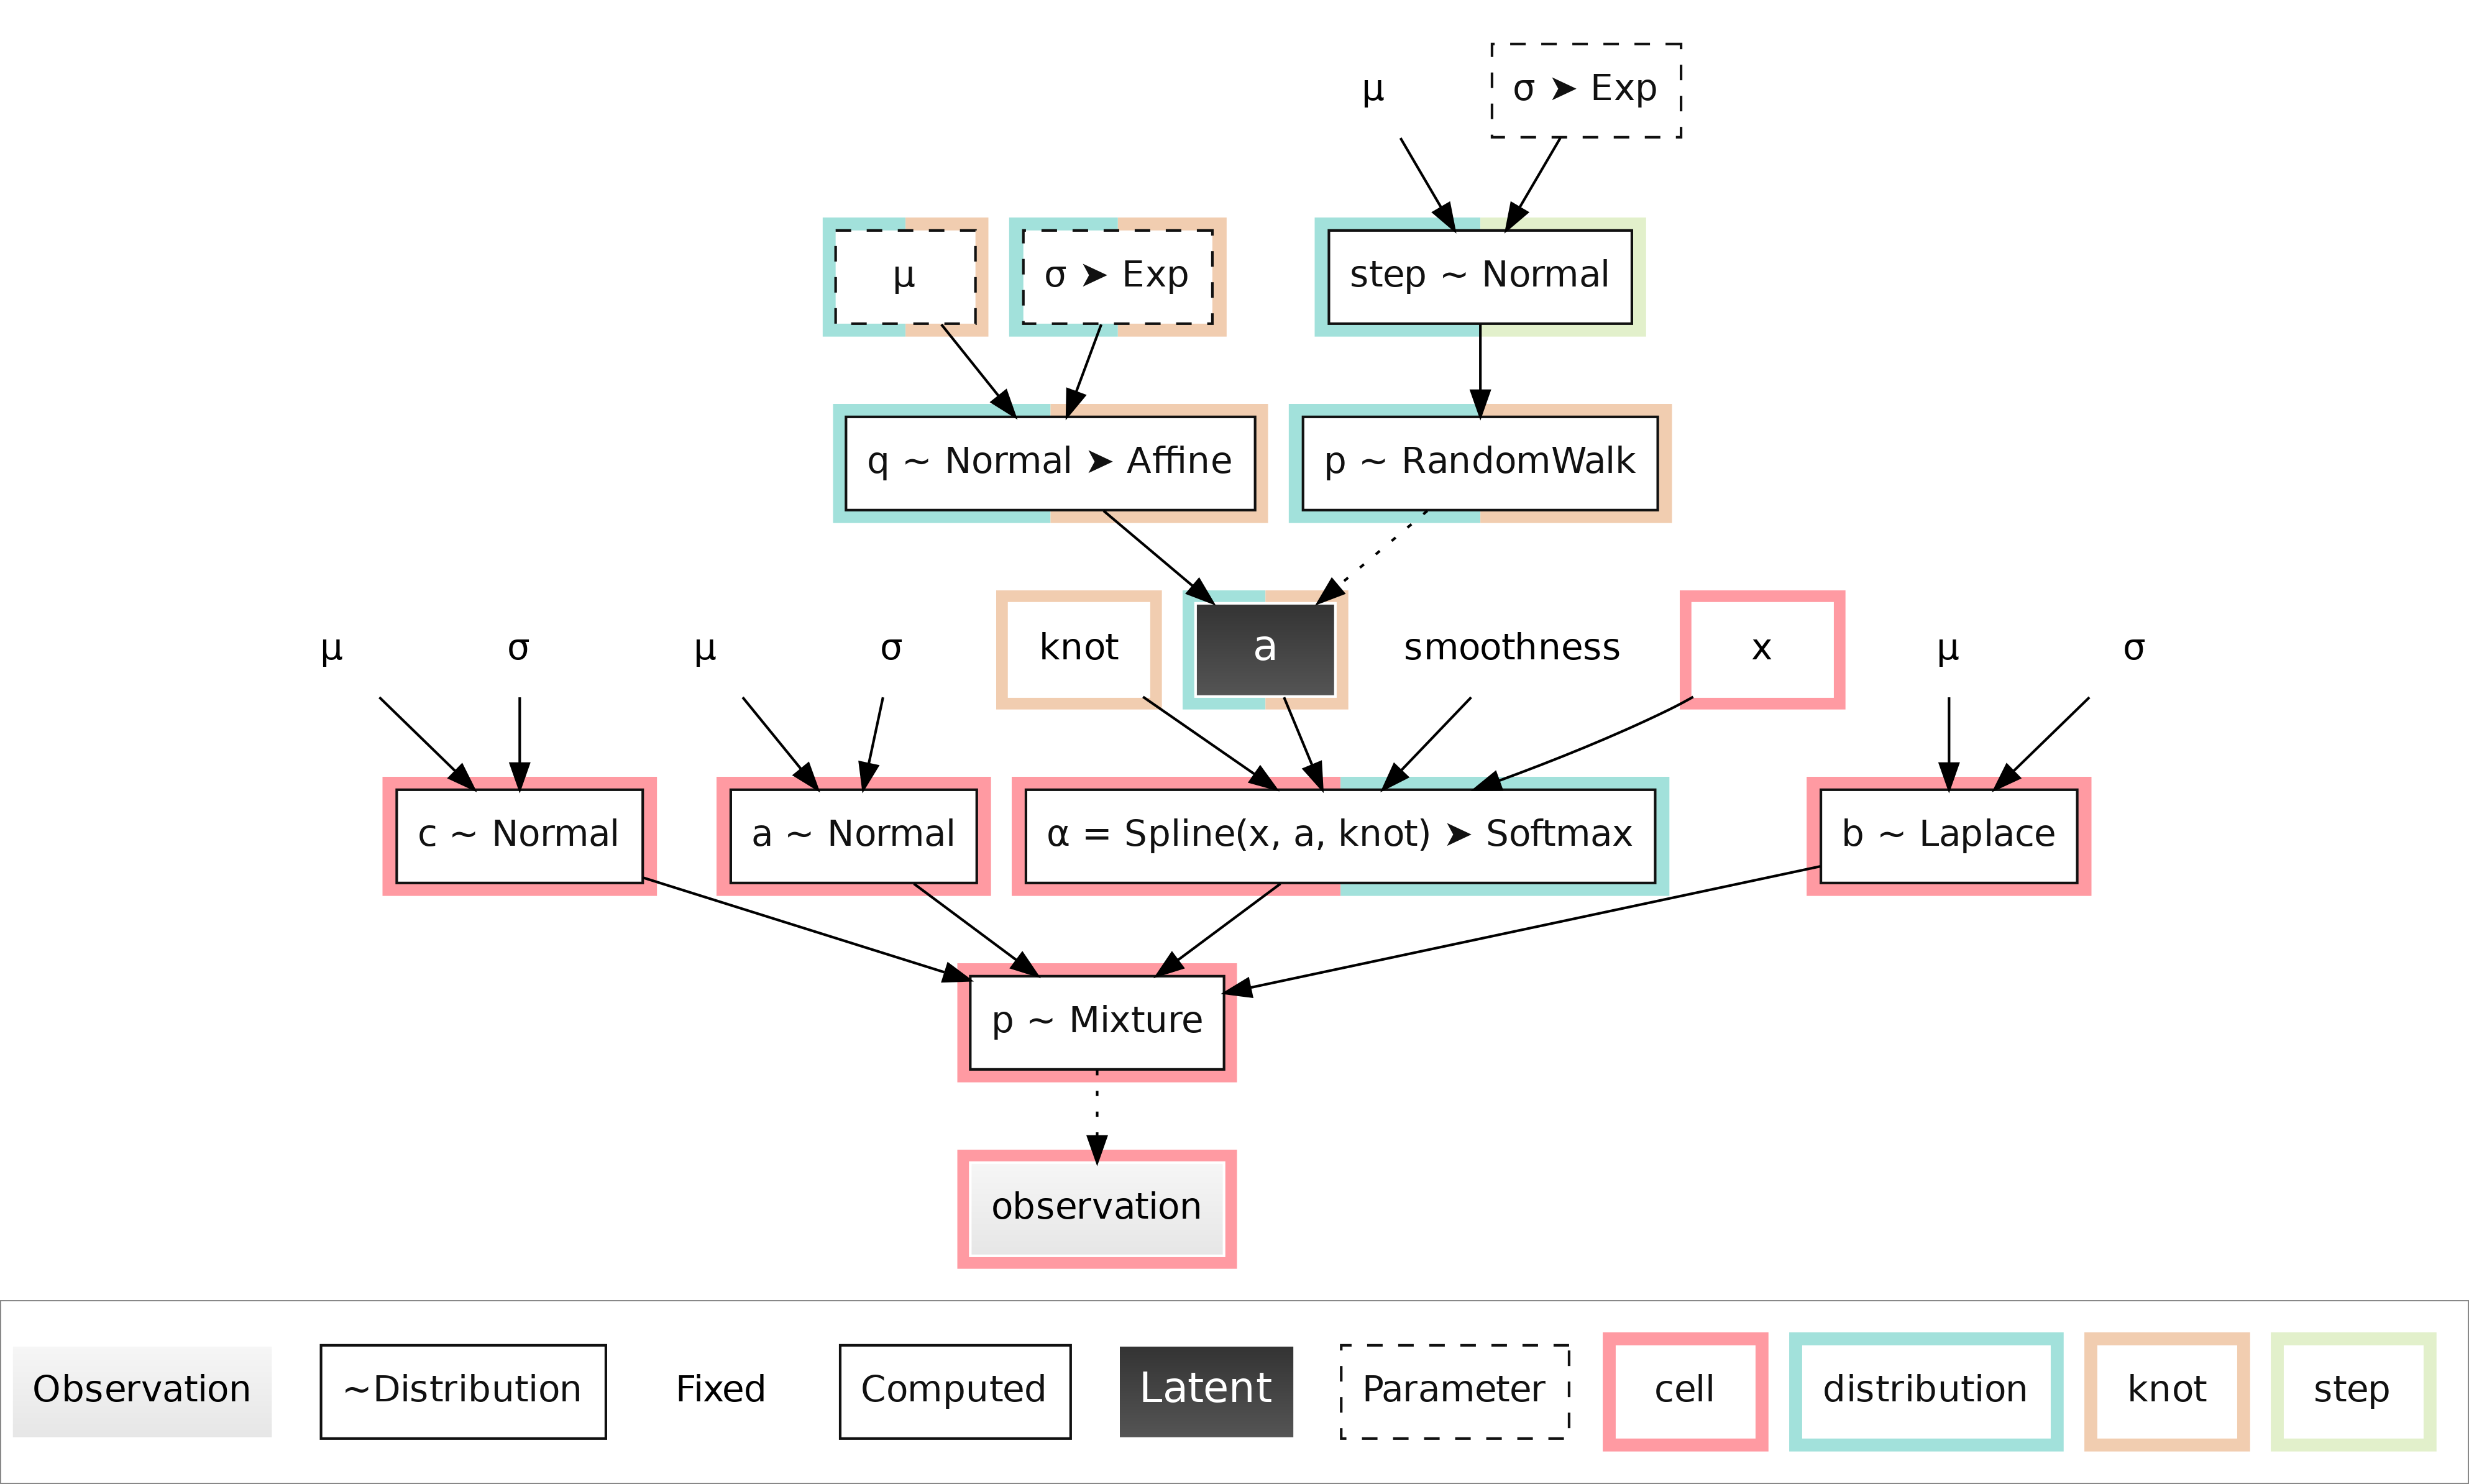

In [22]:
x = x_gs.clone()
coefficients = la.links.scalar.Spline(
    x,
    output=w,
    label="coefficients",
    transforms=[la.transforms.Softmax(dimension = distributions_dim)],
    output_distribution=la.distributions.Normal(),
)
dist = la.distributions.Mixture(weight=coefficients, distributions = distributions_gs)
observation = la.Observation(observation_value, dist, label="observation")
observation.plot()

In [23]:
inference = la.infer.svi.SVI(
    observation, [la.infer.loss.ELBO()], la.infer.optim.Adam(lr=0.01)
)
trainer = la.infer.trainer.Trainer(inference)
trace = trainer.train(3000)

  0%|                                                                                                         …

In [24]:
posterior = la.posterior.scalar.ScalarObserved(observation)
posterior.sample(10)

  0%|          | 0/10 [00:00<?, ?it/s]

In [27]:
assert posterior.likelihood / n_cells > -3

<AxesSubplot:>

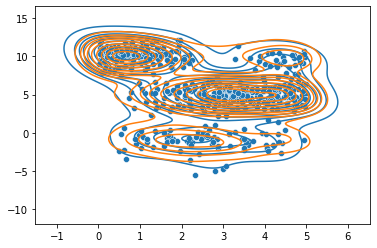

In [32]:
sns.scatterplot(x=x_value, y=observation_value)
sns.kdeplot(x=x_value, y=observation_value)

modelled_value = posterior.samples[observation.p].stack(cells=("sample", "cell")).to_pandas()
modelled_x = posterior.samples[x].stack(cells=("sample", "cell")).to_pandas()
sns.kdeplot(x=modelled_x, y=modelled_value)

Quantitatively check whether the densities are modelled correctly

In [48]:
kde_modelled = scipy.stats.gaussian_kde(np.vstack([modelled_x, modelled_value]))
points = np.array(np.meshgrid(np.linspace(-1, 6, 20), np.linspace(-10, 15, 20))).T.reshape(2, -1)

evaluated_modelled = kde_modelled.evaluate(points)
evaluated_groundtruth = kde_groundtruth.evaluate(points)

kl_divergence = (evaluated_groundtruth * (np.log(evaluated_groundtruth) - np.log(evaluated_modelled))).sum()

np.sqrt(((evaluated_modelled - evaluated_groundtruth)**2).sum()) < 0.1

True

Assess how x changes the observation

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

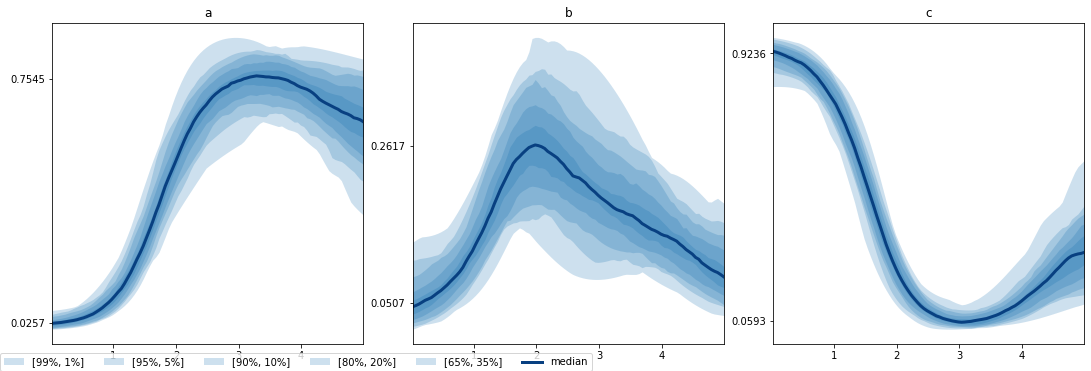

In [49]:
causal = la.posterior.scalar.ScalarVectorCausal(x, observation)
causal.sample(100)
causal.observed.sample()

causal.plot_features();

## Modelling the mixture weights with latent x

A one-dimensional ouput is of course not enough to recapitulate an actual latent x. All we can do is to find an x that can distinguishes the 3 components

In [50]:
x = la.Latent(la.distributions.Uniform(0.0, 5.0), definition=x)

In [51]:
coefficients = la.links.scalar.Spline(
    x,
    output=w,
    label="coefficients",
    transforms=[la.transforms.Softmax(dimension = distributions_dim)],
    output_distribution=la.distributions.Normal(),
)

In [52]:
dist = la.distributions.Mixture(weight = coefficients, distributions = distributions_gs)

In [53]:
observation = la.Observation(observation_value, dist, label="observation")


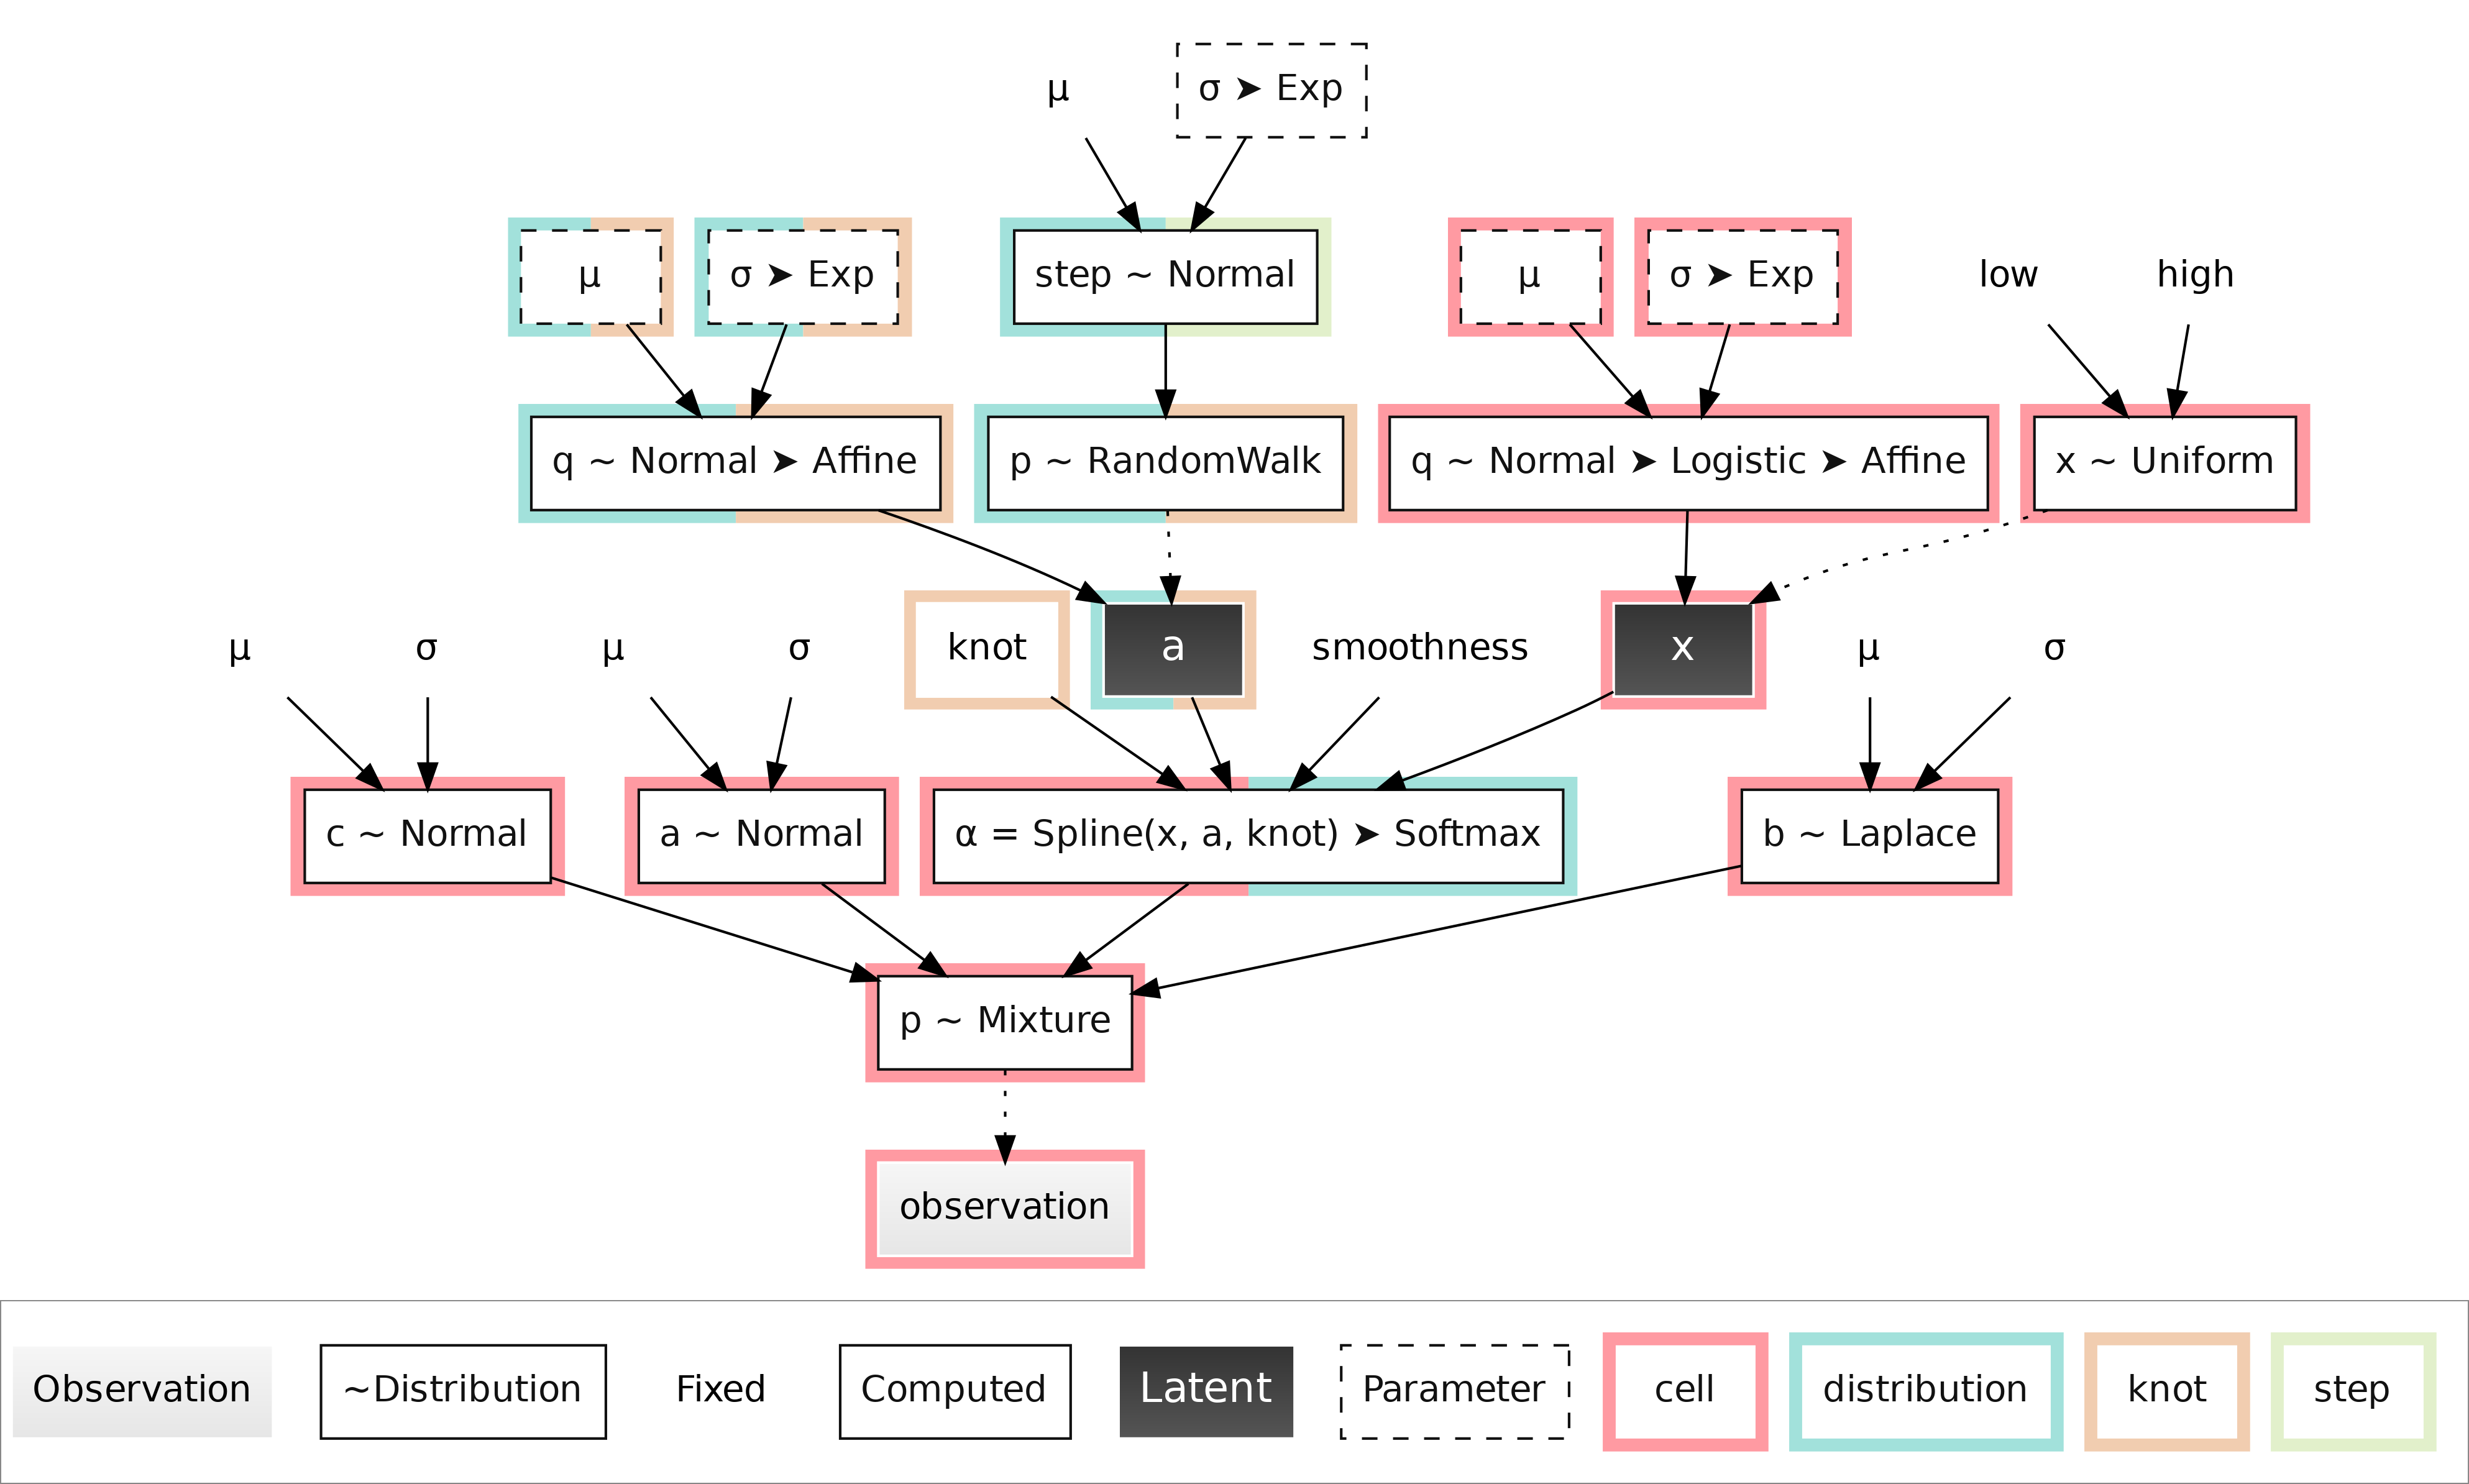

In [54]:
observation.plot()

In [55]:
inference = la.infer.svi.SVI(
    observation, [la.infer.loss.ELBO()], la.infer.optim.Adam(lr=0.01)
)
trainer = la.infer.trainer.Trainer(inference)
trace = trainer.train(10000)

  0%|                                                                                                         …

In [28]:
posterior = la.posterior.Posterior(observation)
posterior.sample(10)

  0%|          | 0/10 [00:00<?, ?it/s]

In [29]:
assert posterior.likelihood / n_cells > -3

<AxesSubplot:>

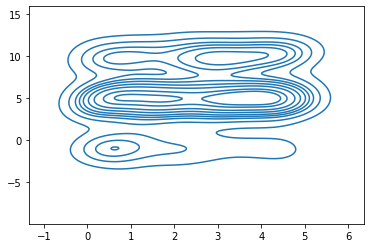

In [30]:
modelled_value = posterior.samples[observation.p].stack(cells=("sample", "cell")).to_pandas()
modelled_x = posterior.samples[x].stack(cells=("sample", "cell")).to_pandas()
sns.kdeplot(x=modelled_x, y=modelled_value)

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

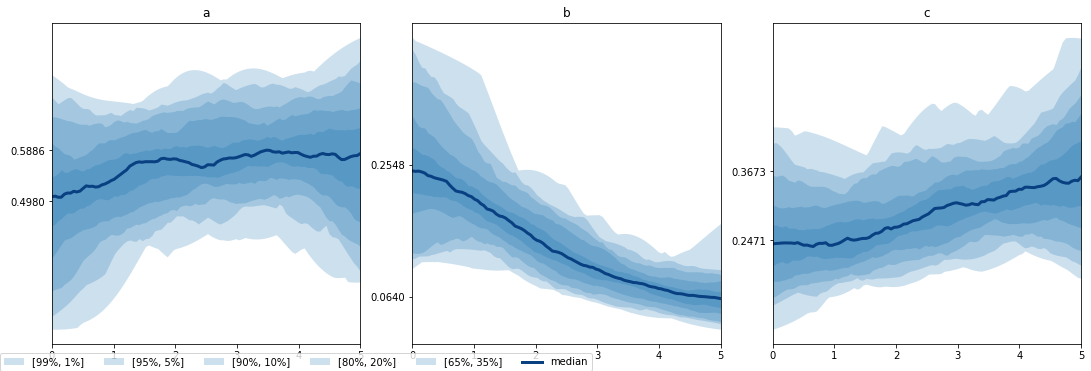

In [31]:
causal = la.posterior.scalar.ScalarVectorCausal(x, observation)
causal.sample(100)
causal.observed.sample()

causal.plot_features();

## Modelling the mixture weights with given x and unknown distribution parameters


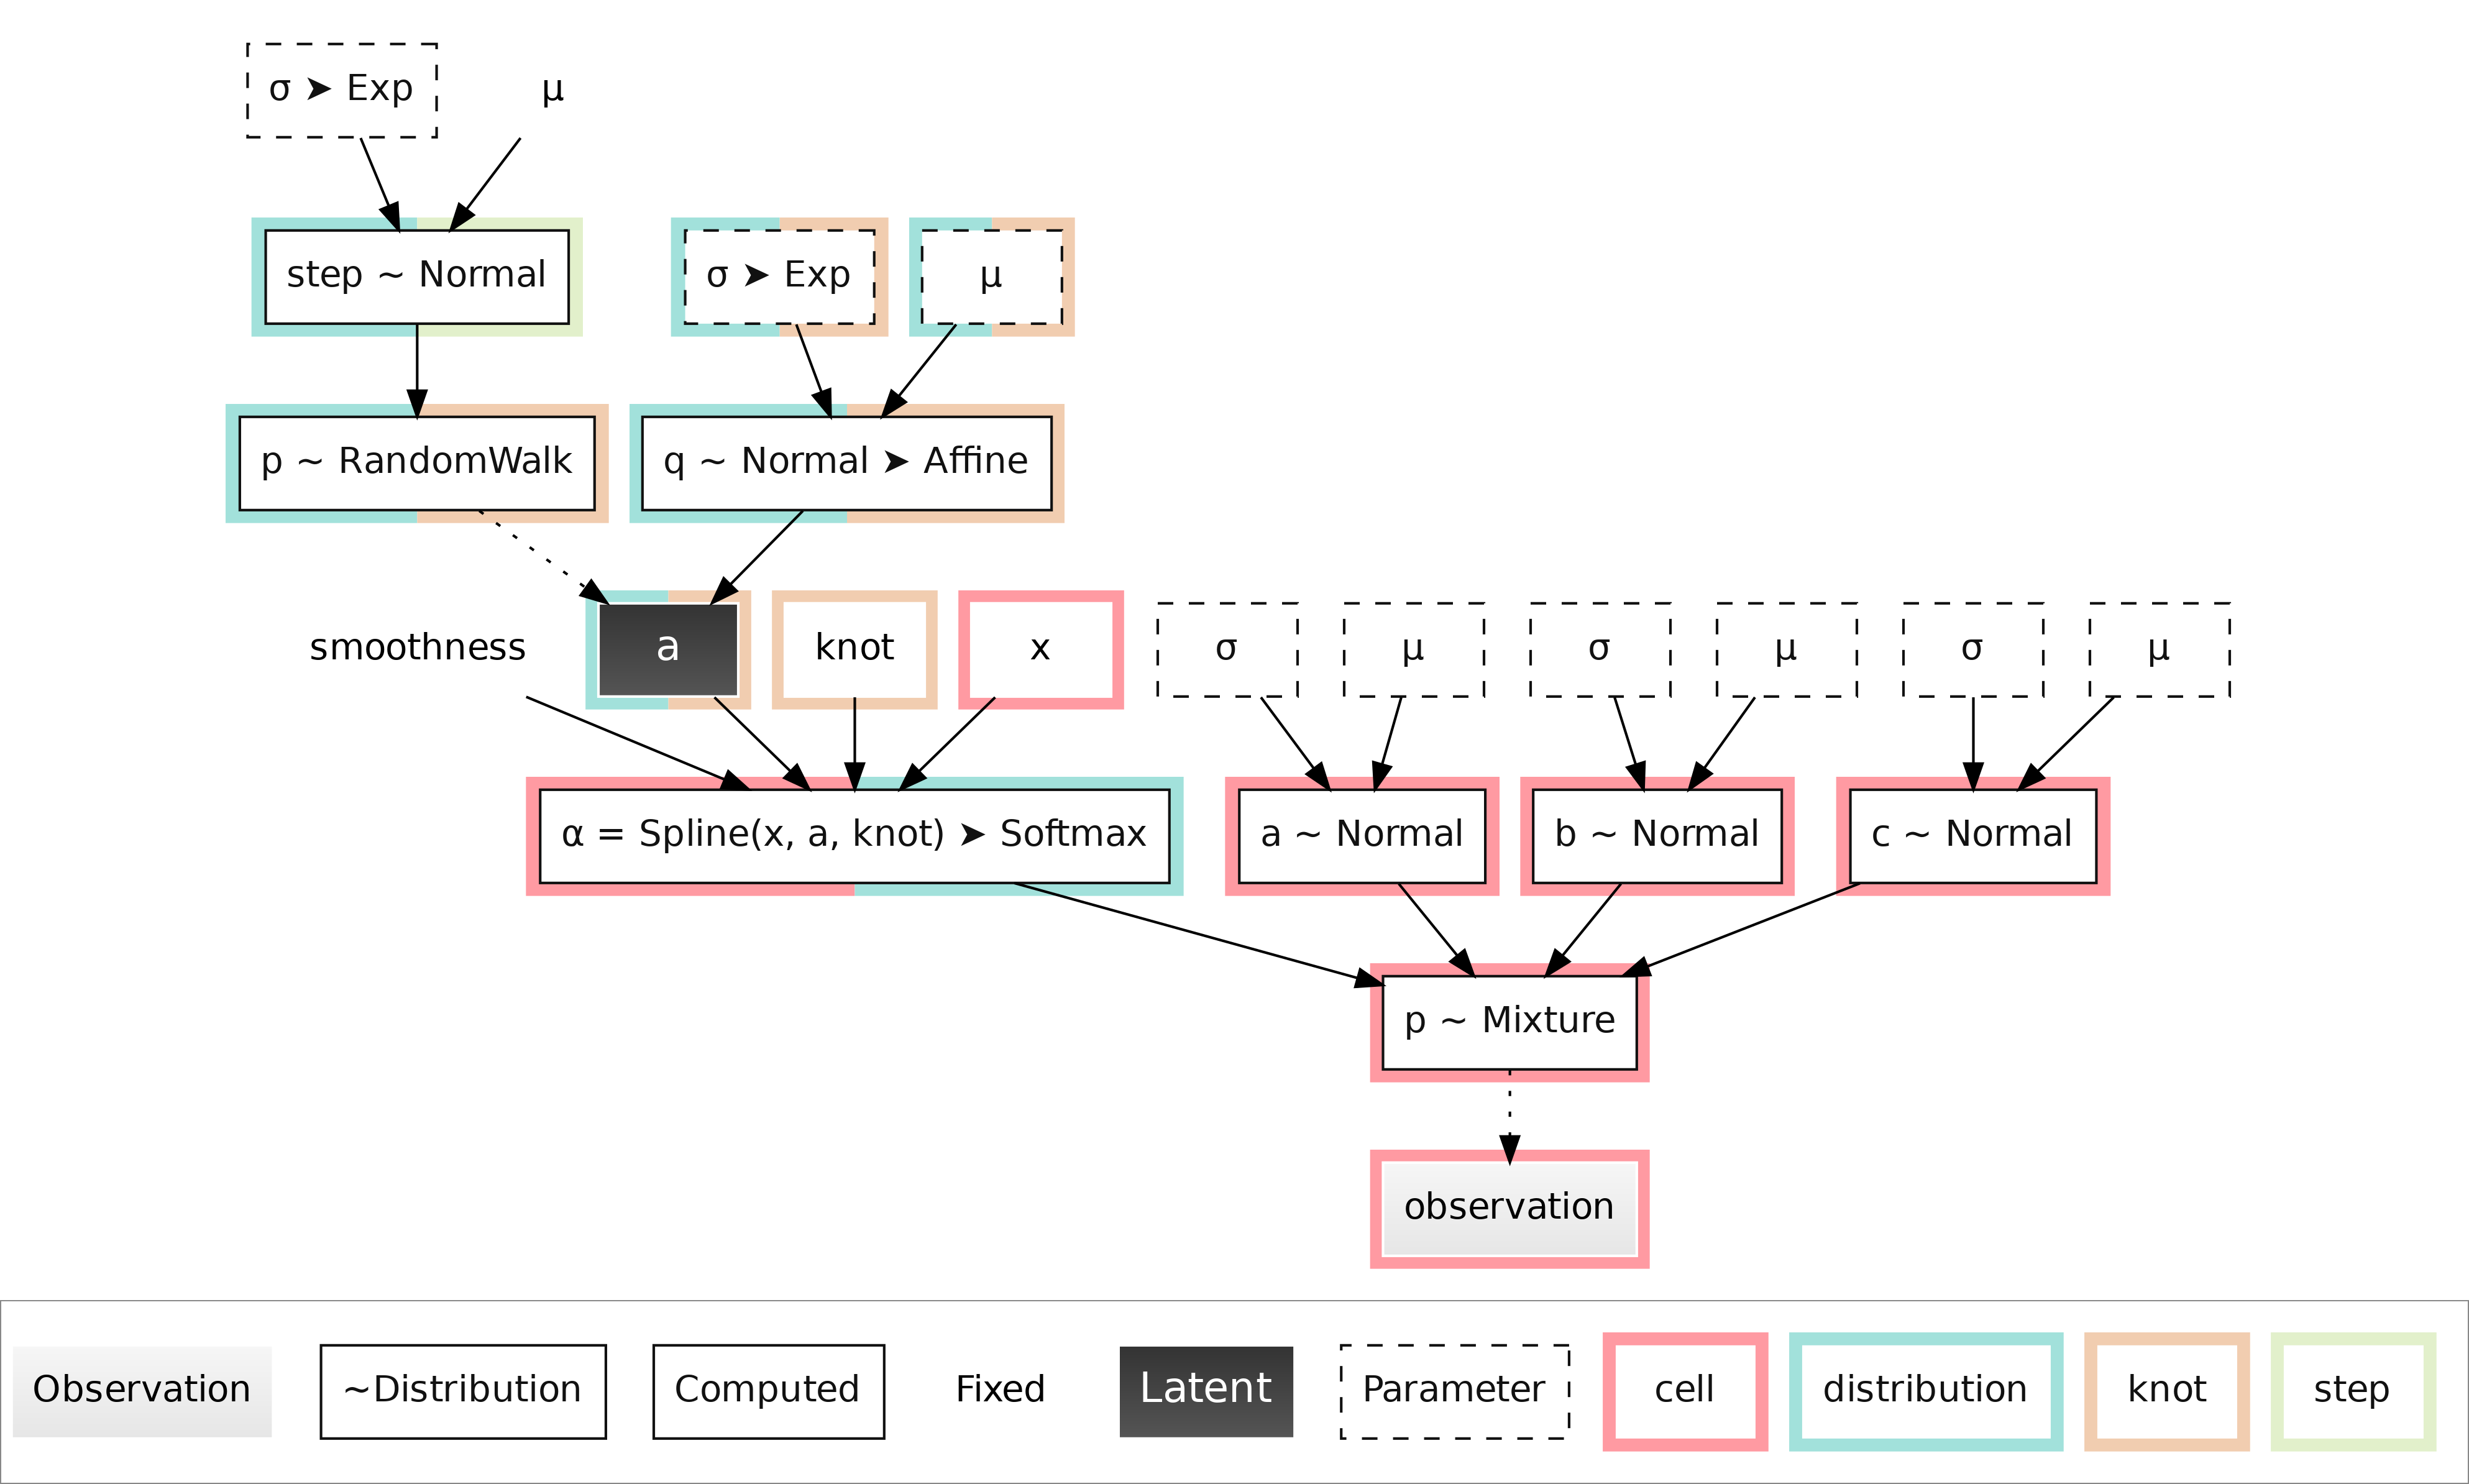

In [32]:
x = x_gs.clone()
distributions = {distribution_id:la.distributions.Normal(la.Parameter(0.), la.Parameter(1.)) for distribution_id in "abc"}
distributions_dim = la.Dim(distributions.keys(), "distribution")

coefficients = la.links.scalar.Spline(
    x,
    output=la.Definition([cells, distributions_dim]),
    label="coefficients",
    transforms=[la.transforms.Softmax(dimension = distributions_dim)],
    output_distribution=la.distributions.Normal(),
)
dist = la.distributions.Mixture(weight=coefficients, distributions = distributions)
observation = la.Observation(observation_value, dist, label="observation")
observation.plot()

In [33]:
inference = la.infer.svi.SVI(
    observation, [la.infer.loss.ELBO()], la.infer.optim.Adam(lr=0.01)
)
trainer = la.infer.trainer.Trainer(inference)
trace = trainer.train(10000)

  0%|                                                                                                         …

In [34]:
posterior = la.posterior.scalar.ScalarObserved(observation)
posterior.sample(10)

  0%|          | 0/10 [00:00<?, ?it/s]

In [35]:
assert posterior.likelihood / n_cells > -3

<AxesSubplot:>

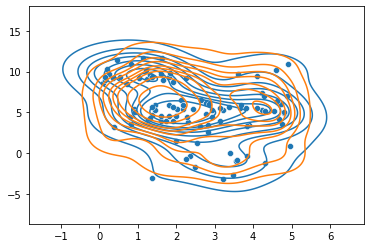

In [36]:
sns.scatterplot(x=x_value, y=observation_value)
sns.kdeplot(x=x_value, y=observation_value)

modelled_value = posterior.samples[observation.p].stack(cells=("sample", "cell")).to_pandas()
modelled_x = posterior.samples[x].stack(cells=("sample", "cell")).to_pandas()
sns.kdeplot(x=modelled_x, y=modelled_value)

Quantitatively check whether the densities are modelled correctly

In [37]:
kde_modelled = scipy.stats.gaussian_kde(np.vstack([modelled_x, modelled_value]))
points = np.array(np.meshgrid(np.linspace(-1, 6, 20), np.linspace(-10, 15, 20))).T.reshape(2, -1)

evaluated_modelled = kde_modelled.evaluate(points)
evaluated_groundtruth = kde_groundtruth.evaluate(points)

kl_divergence = (evaluated_groundtruth * (np.log(evaluated_groundtruth) - np.log(evaluated_modelled))).sum()

assert (evaluated_modelled - evaluated_groundtruth).sum() > -0.5

Assess how x changes the observation

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

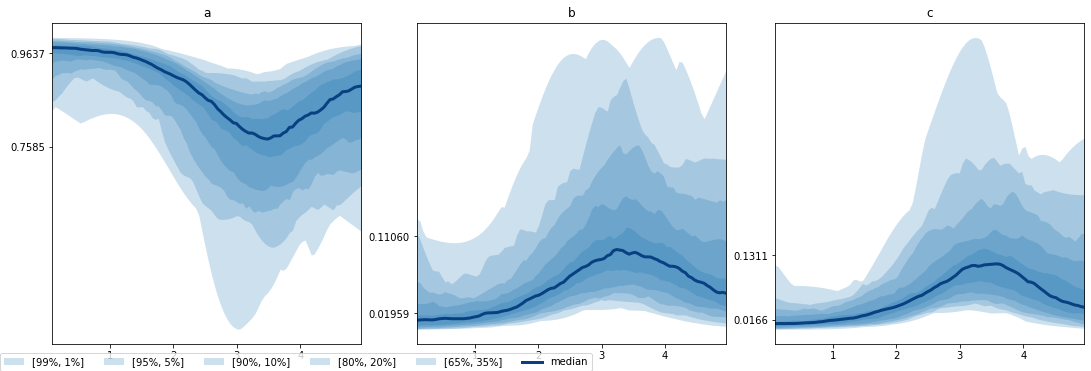

In [38]:
causal = la.posterior.scalar.ScalarVectorCausal(x, observation)
causal.sample(100)
causal.observed.sample()

causal.plot_features();

## Modelling the mixture weights with given x and latent distribution parameters


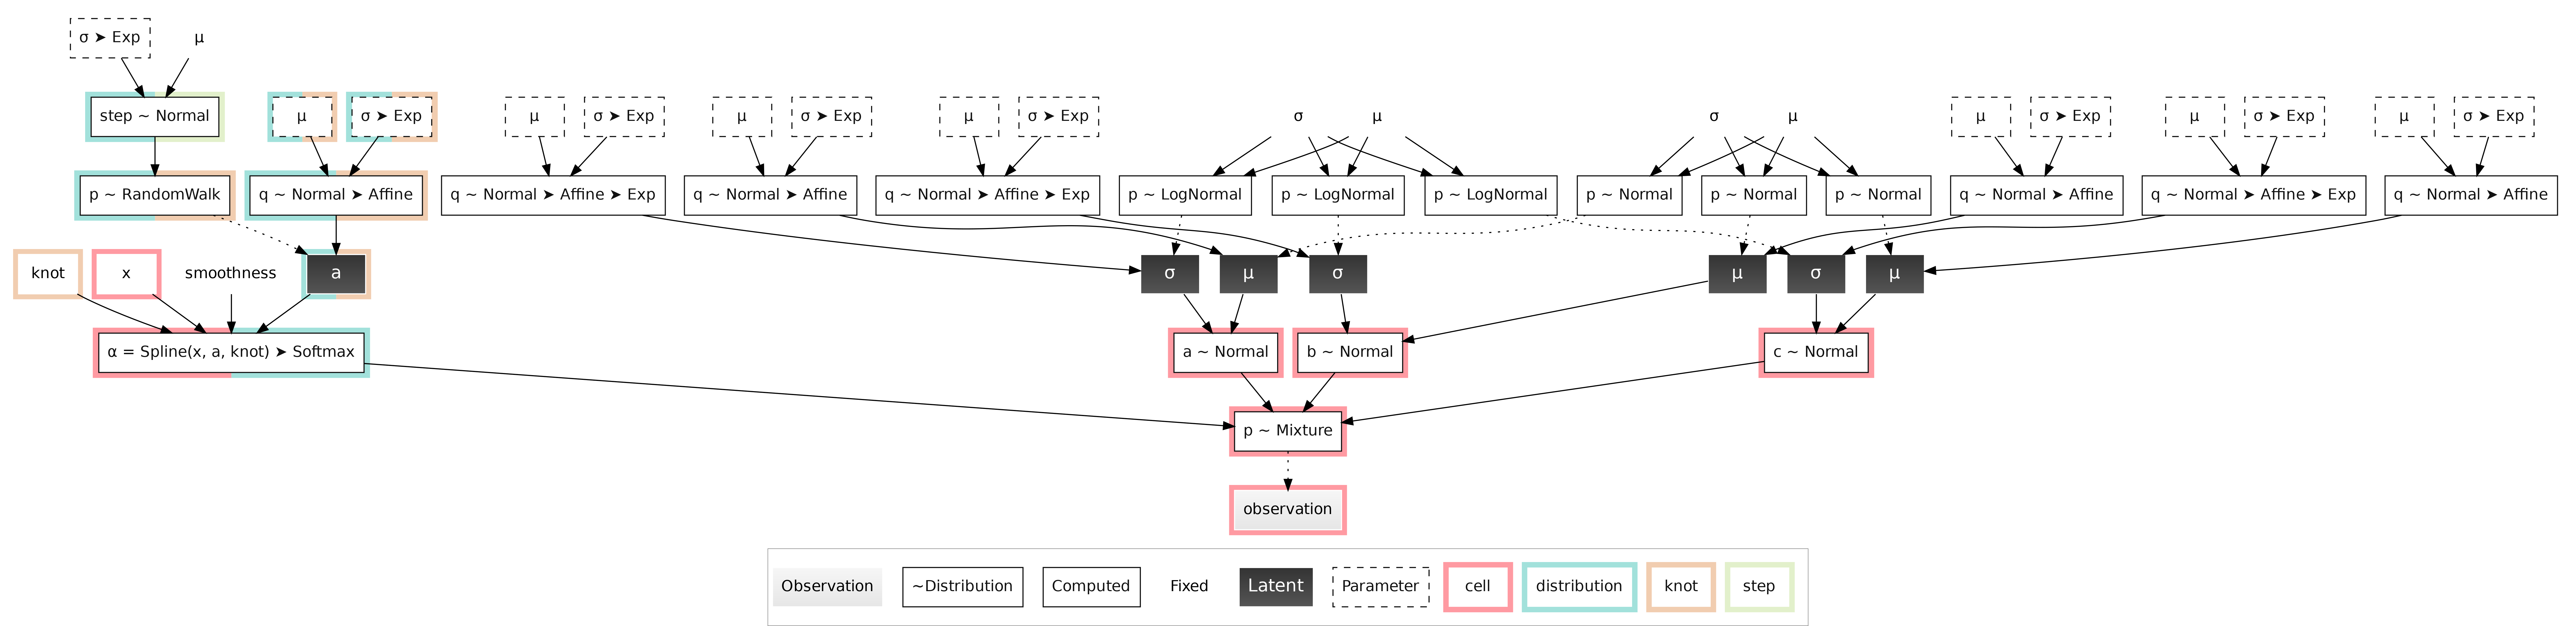

In [39]:
x = x_gs.clone()
distribution_loc_p = la.distributions.Normal(scale = 5.)
distribution_scale_p = la.distributions.LogNormal(scale = 2.)
distributions = {
    distribution_id:la.distributions.Normal(
        la.Latent(distribution_loc_p),
        la.Latent(distribution_scale_p)
) for distribution_id in "abc"}
distributions_dim = la.Dim(distributions.keys(), "distribution")

coefficients = la.links.scalar.Spline(
    x,
    output=la.Definition([cells, distributions_dim]),
    label="coefficients",
    transforms=[la.transforms.Softmax(dimension = distributions_dim)],
    output_distribution=la.distributions.Normal(),
)
dist = la.distributions.Mixture(weight=coefficients, distributions = distributions)
observation = la.Observation(observation_value, dist, label="observation")
observation.plot()

In [40]:
inference = la.infer.svi.SVI(
    observation, [la.infer.loss.ELBO()], la.infer.optim.Adam(lr=0.05)
)
trainer = la.infer.trainer.Trainer(inference)
trace = trainer.train(10000)

  0%|                                                                                                         …

In [41]:
posterior = la.posterior.scalar.ScalarObserved(observation)
posterior.sample(10)

  0%|          | 0/10 [00:00<?, ?it/s]

In [42]:
assert posterior.likelihood / n_cells > -3

<AxesSubplot:>

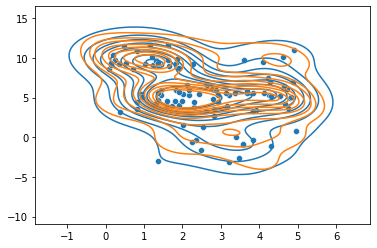

In [43]:
sns.scatterplot(x=x_value, y=observation_value)
sns.kdeplot(x=x_value, y=observation_value)

modelled_value = posterior.samples[observation.p].stack(cells=("sample", "cell")).to_pandas()
modelled_x = posterior.samples[x].stack(cells=("sample", "cell")).to_pandas()
sns.kdeplot(x=modelled_x, y=modelled_value)

Quantitatively check whether the densities are modelled correctly

In [44]:
kde_modelled = scipy.stats.gaussian_kde(np.vstack([modelled_x, modelled_value]))
points = np.array(np.meshgrid(np.linspace(-1, 6, 20), np.linspace(-10, 15, 20))).T.reshape(2, -1)

evaluated_modelled = kde_modelled.evaluate(points)
evaluated_groundtruth = kde_groundtruth.evaluate(points)

kl_divergence = (evaluated_groundtruth * (np.log(evaluated_groundtruth) - np.log(evaluated_modelled))).sum()

assert (evaluated_modelled - evaluated_groundtruth).sum() > -0.5

Assess how x changes the observation

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

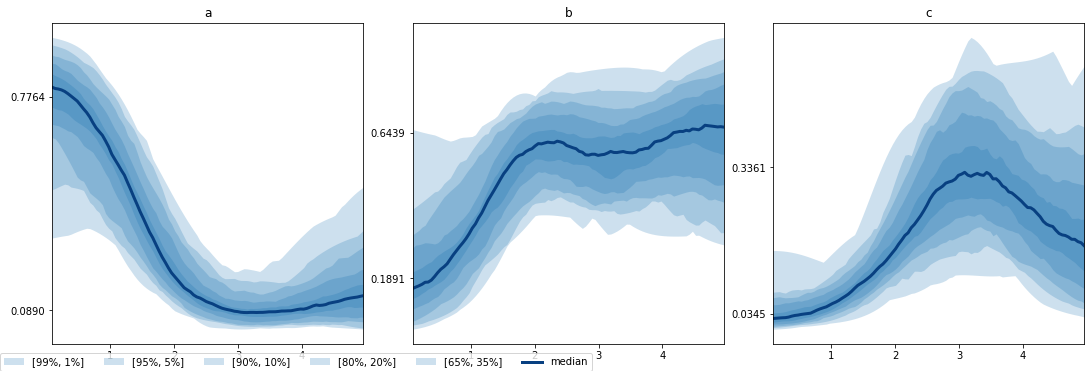

In [45]:
causal = la.posterior.scalar.ScalarVectorCausal(x, observation)
causal.sample(100)
causal.observed.sample()

causal.plot_features();